# Melanoma Classification - Downsampling

The ISIC 2020 dataset is very skewed. It includes far more samples labeled as no-melanoma, than samples labeled as melanoma (1.78%). Even when combining the dataset with the ISIC 2019 dataset, which has a higher percentage of positive samples (17.85%), only around 9% posite samples can be achieved. 


The skewed data leads to bad models which are likely to overfit. For this reason, the data shall be downsampled in the following. That means that some samples classified as no-melanoma will be removed from the dataset in order to achieve a ore even contribution. 


Another option would be upsampling, where the samples labeled as positive are multiplied. Since we however already have a huge dataset which we are struggeling to fit on the cluster, this approach is not suitable.

## Setup

where to get the data from

In [1]:
data_base_path = "data"
ground_truth_base_file_name = "ISIC_2020_2019" 

partitions = ["train", "test"]

where to download the data to

In [2]:
downsampled_suffix = "_downsampled"

percentage of melanoma samples after downsampling

In [3]:
goal_percentage_positive_sample = 0.3

set up for utilities

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

random state

In [5]:
from utilities import random_state
random_state = random_state() 

## Load Groundtruth Data

In [6]:
import pandas as pd

datasets = []

for p in partitions:
    groundtruth_file_name = data_base_path + "/" + ground_truth_base_file_name + "_" + p + ".csv"
    print("Reading groundtruth " + groundtruth_file_name)
    datasets.append(pd.read_csv(groundtruth_file_name, index_col=0))

Reading groundtruth data/ISIC_2020_2019_train.csv
Reading groundtruth data/ISIC_2020_2019_test.csv
Reading groundtruth data/ISIC_2020_2019_valid.csv


## Split into positive and negative samples

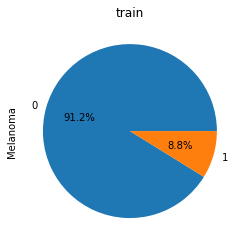

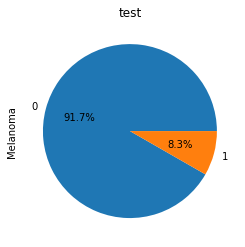

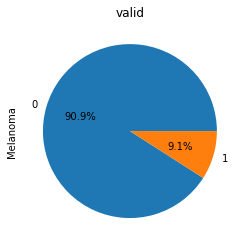

In [7]:
import matplotlib.pyplot as plt # for showing images

for i in range(len(partitions)):
    samples = datasets[i]
    
    samples.groupby('target').size().plot(kind='pie',
                                        y = "target",
                                        label="Melanoma",
                                        title = partitions[i],
                                        autopct='%1.1f%%')
    plt.show()
    
    positive = samples[samples["target"] == 1]
    negative  = samples[samples["target"] == 0]
    
    datasets[i] = [negative, positive]

## Downsampling

In [8]:
import numpy as np

for i in range(len(partitions)):
    num_positive_samples = datasets[i][1].count()[0]
    num_negative_samples = datasets[i][0].count()[0]
    
    img_names = datasets[i][0]["image_name"].values.tolist()
    
    print(f'Downsampling {partitions[i]}\nBefore:\nnegative samples: {num_negative_samples} positive samples: {num_positive_samples}')

    goal_num_samples = int(num_positive_samples * (1/goal_percentage_positive_sample))
    goal_num_negative_samples = goal_num_samples - num_positive_samples
    
    np.random.seed(random_state)
    negative_downsample = np.random.choice(datasets[i][0]["image_name"], size=goal_num_negative_samples, replace=False)
    negative_downsample = datasets[i][0][datasets[i][0]['image_name'].isin(negative_downsample)] 
 
    new_num_negative = negative_downsample.count()[0]
    print(f'After:\nnegative samples: {new_num_negative} positive samples: {num_positive_samples}')
    
    datasets[i] = pd.concat([datasets[i][1], negative_downsample])
    
    img_names = negative_downsample["image_name"].values.tolist()

Downsampling train
Before:
negative samples: 42329 positive samples: 4096
After:
negative samples: 16384 positive samples: 4096
Downsampling test
Before:
negative samples: 5323 positive samples: 481
After:
negative samples: 1924 positive samples: 481
Downsampling valid
Before:
negative samples: 5277 positive samples: 526
After:
negative samples: 2104 positive samples: 526


## Saving to disk (Groundtruth)

In [9]:
for i in range(len(partitions)):
    name = data_base_path + "/" + ground_truth_base_file_name + "_" + partitions[i] + downsampled_suffix + ".csv"
    print("Downloading to ", name)
    datasets[i].to_csv(name)

## Saving to disk (Images)

In [10]:
import os
import shutil

for i in range(len(partitions)):
    downsampled_folder = data_base_path + "/" + partitions[i] + downsampled_suffix
    original_folder = data_base_path + "/" + partitions[i] 
    
    if not os.path.exists(downsampled_folder): 
          os.makedirs(downsampled_folder)
          print("Created new directory %s" %downsampled_folder)
        
    img_names = datasets[i]["image_name"].values.tolist()
    
    print(f"Start moving {len(img_names)} images to {downsampled_folder}")
        
    for img_name in img_names:
        fname = original_folder + "/" + img_name + ".jpg"
        shutil.copy(fname, downsampled_folder)
    
    print("Finished moving images to ", downsampled_folder)

Created new directory data/train_downsampled
Start moving 20480 images to data/train_downsampled
Finished moving images to  data/train_downsampled
Created new directory data/test_downsampled
Start moving 2405 images to data/test_downsampled
Finished moving images to  data/test_downsampled
Created new directory data/valid_downsampled
Start moving 2630 images to data/valid_downsampled
Finished moving images to  data/valid_downsampled
